In [10]:
#%%
from skimage import io
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy
import scipy.ndimage
from scipy import spatial
from shapely.geometry import Point, MultiPoint
from shapely.geometry.polygon import Polygon
from numpy import asarray
import requests
from io import BytesIO

#####################-------VARS
num_samples = 2000
iterations = 2
contrast_factor = 2
threshold = 80
#############


url = "https://images.cdn.nouveau.nl/uht4d7Cv8B3f3LESHFMGvsGs9AA=/890x0/smart/nouveau.nl/s3fs-public/main_media/nouveau-van-gogh-03.jpg?itok=VzUOxxS_"


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

original_img = (io.imread(url))
original_img = rgb2gray(original_img)   
def show_image(image):
    fig = plt.figure()  
    ax = plt.axes([0,0,1,1])
    ax.set_axis_off()
    plt.box(False)
    fig.add_axes(ax)
    ax.imshow(image, aspect='equal')

def process_image(image, contrast_factor):
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(contrast_factor)
    return image 
    
def pil_to_plt(image):
    image = np.asarray(image)
    return image

def normalize(D):
    Vmin, Vmax = D.min(), D.max()
    if Vmax - Vmin > 1e-5:
        D = (D-Vmin)/(Vmax-Vmin)
    else:
        D = np.zeros_like(D)
    return D

def density_region_points(image):
    zoom = (num_samples * 500) / (image.shape[0] * image.shape[1])
    zoom = int(round(np.sqrt(zoom)))
    density = scipy.ndimage.zoom(image, zoom, order=0)

    # Apply threshold onto image
    # Any color > threshold will be white
    density = np.minimum(density, threshold)
    density = 1.0 - normalize(density)
    density = np.flipud(density) 

    x_min, x_max = 0, density.shape[1]
    y_min, y_max = 0, density.shape[0]

    bounding_box = np.array([x_min, x_max, y_min, y_max])

    samples = []
    while len(samples) < num_samples:
        # X = np.random.randint(0, D.shape[1], 10*n)
        # Y = np.random.randint(0, D.shape[0], 10*n)
        X = np.random.uniform(0, density.shape[0], 10*num_samples)
        Y = np.random.uniform(0, density.shape[1], 10*num_samples)
        P = np.random.uniform(0, 1, 10*num_samples)
        index = 0
        while index < len(X) and len(samples) < num_samples:
            x, y = X[index], Y[index]
            x_, y_ = int(np.floor(x)), int(np.floor(y))
            if P[index] < density[x_, y_]:
                samples.append([x, y])
            index += 1
    samples = np.fliplr(np.array(samples))
    return bounding_box, density, zoom, samples

def bound_polygon(points, bounding_box):
    # idea from https://stackoverflow.com/questions/28665491/getting-a-bounded-polygon-coordinates-from-voronoi-cells
    # get points inside bounding box
    i = np.logical_and(
        np.logical_and(bounding_box[0] <= points[:, 0], points[:, 0] <= bounding_box[1]), 
        np.logical_and(bounding_box[2] <= points[:, 1], points[:, 1] <= bounding_box[3])
    )
    #
    points_original = points[i, :]
    #
    points_left = np.copy(points_original)
    points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])
    #
    points_right = np.copy(points_original)
    points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])
    #
    points_down = np.copy(points_original)
    points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])
    #
    points_up = np.copy(points_original)
    points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])
    #
    points = np.append(points_original, np.append(np.append(points_left, points_right, axis=0), np.append(points_down, points_up, axis=0), axis=0), axis=0)
    #
    return points, points_original

def voronoi_func(bounding_box, points):
    eps = 0.5
    regions = []
    new_points, points_original = bound_polygon(points, bounding_box)
    voronoi = spatial.Voronoi(new_points)
    #
    for region in voronoi.regions:
        flag = True
        for index in region:
            if index == -1:
                flag = False
                break
            else:
                x = voronoi.vertices[index, 0]
                y = voronoi.vertices[index, 1]
                if not(bounding_box[0]-eps <= x <= bounding_box[1]+eps and
                       bounding_box[2]-eps <= y <= bounding_box[3]+eps):
                    flag = False
                    break
        if region != [] and flag:
            regions.append(region)
    #
    voronoi.filtered_points = points_original
    voronoi.filtered_regions = regions
    #
    return voronoi

def weighted_centroid(vertices, density):
    points = []
    for vertex in vertices:
        points.append((vertex[0], vertex[1]))
    polygon = MultiPoint(points)
    x_min = int(math.floor(polygon.bounds[1]))
    x_max = int(math.floor(polygon.bounds[3]))
    y_min = int(math.floor(polygon.bounds[0]))
    y_max = int(math.floor(polygon.bounds[2]))
    weight_sum = 0
    x_sum = 0
    y_sum = 0
    for x in range(x_min, x_max):
        for y in range(y_min, y_max):
            if(polygon.contains(Point(x,y) or polygon.intersects(Point(x,y)))):
                x_sum += x*density[x][y]
                y_sum += y*density[x][y]
                weight_sum += density[x][y]

    if(weight_sum > 0):          
        x_centroid = x_sum / weight_sum
        y_centroid = y_sum / weight_sum
        return [x_centroid, y_centroid]
    else:

        return asarray(polygon.centroid)

def centroids(points, density):
    """
    Given a set of point and a density array, return the set of weighted
    centroids.
    """
    xmin, xmax = 0, density.shape[1]
    ymin, ymax = 0, density.shape[0]
    bounding_box = [xmin, xmax, ymin, ymax]
    vor = voronoi_func(bounding_box, points)
    regions = vor.filtered_regions
    centroids = []
    for region in regions:
        vertices = vor.vertices[region, :]
        # vertices = vor.filtered_points[region + [region[0]], :]

        # Full version from all the points
        centroid = weighted_centroid(vertices, density)

        centroids.append(centroid)
    return regions, np.array(centroids)



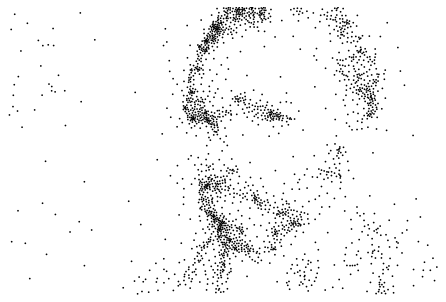

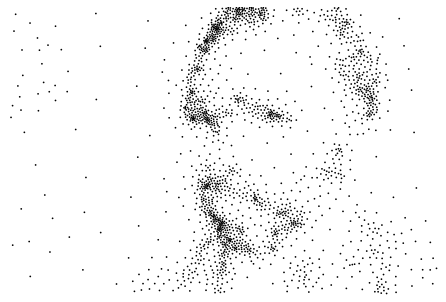

In [11]:

image = pil_to_plt(original_img)
bounding_box, density, zoom, points = density_region_points(image)

x_min = bounding_box[0]
x_max = bounding_box[1]
y_min = bounding_box[2]
y_max = bounding_box[3]
ratio = (x_max-x_min)/(y_max-y_min)

for i in range(iterations):
    regions, points = centroids(points, density)

    fig = plt.figure(facecolor="white")
    ax = fig.add_axes([0, 0, 1, 1], frameon=False)
    ax.set_xlim([x_min, x_max])
    ax.set_xticks([])
    ax.set_ylim([y_min, y_max])
    ax.set_yticks([])
    scatter = ax.scatter(points[:, 0], points[:, 1], s=3, facecolor="k", edgecolor="None")
    plt.savefig(""+ str(num_samples) + "_"+ str(i) + ".png")